In [1]:
import numpy as np
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import h5py

#### 1) Open $C^*$ values (in mmol/m$^3$) for all years (1992-2022) and store them as a stacked array.

For each year, $C^*(x,y,z)$ is on a regular (lat, lon, depth) grid with $(180, 360, 50)$ grid points.

In [3]:
data_folder = "../raw_Cstar_data/"
years = list(range(1992, 2023))  #31 years: 1992 to 2022
cstar_stack = []

#Load each year's file and append to list
for y in years:
    path = os.path.join(data_folder, f"cstar_interp_{y}.h5")
    with h5py.File(path, 'r') as f:
        cstar = f['Cstar'][:] # Use [:] to load data into memory
    cstar_stack.append(cstar)

#Stack
cstar_all = np.stack(cstar_stack, axis=-1)         
print('Shape of stacked array (lat, lon, depth, years): ', cstar_all.shape)

Shape of stacked array (lat, lon, depth, years):  (180, 360, 50, 31)


#### 2) Create dataframe with volume, area, and basin code for each grid cell

In [5]:
# Load grid location data for each data point
with h5py.File('../processed_data/grid.h5', 'r') as f:
    lat = f['latitude'][:] # Use [:] to load data into memory
    lon = f['longitude'][:] 
    depth = f['depth'][:] 

print(lat.shape, lon.shape, depth.shape)

(180, 360, 50) (180, 360, 50) (180, 360, 50)


In [6]:
# Load basin code, region code, and \gamma value for each grid point
with h5py.File('../processed_data/basin_codes.h5', 'r') as f:
    basin_code = f['basin_code'][:] # Use [:] to load data into memory
    region_code = f['region_code'][:] 
    gamma = f['gamma'][:] 

print(basin_code.shape, region_code.shape, gamma.shape)

(180, 360, 50) (180, 360, 50) (180, 360, 50)


In [7]:
# Load area and volume for each grid point
with h5py.File('../processed_data/area_volume.h5', 'r') as f:
    area = f['Area'][:] # Use [:] to load data into memory
    volume = f['Volume'][:] 
    
print(area.shape, volume.shape)

(180, 360, 50) (180, 360, 50)


In [8]:
column_names = ['latitude', 'longitude', 'depth', 'basin_code', 'gamma', 'region_code',
       'Area', 'Volume']
master_df = pd.DataFrame(columns=column_names)

Dataframe columns (each row corresponds to each data point on the $(180, 360, 50)$ grid):

- 'latitude', 'longitude', 'depth'
- 'basin_code': ocean basin codes (1: Atlantic, 2: Pacific, 3: Indian, 4: Southern Ocean, 5: Arctic)
- 'gamma': neutral density $\gamma$ (kg/m$^3$)
- 'region_code': region codes based on ocean basin and neutral density ranges (see paper)
- 'Area', 'Volume'

In [10]:
master_df.columns

Index(['latitude', 'longitude', 'depth', 'basin_code', 'gamma', 'region_code',
       'Area', 'Volume'],
      dtype='object')

In [11]:
master_df['latitude'] = lat.reshape((180*360*50,))
master_df['longitude'] = lon.reshape((180*360*50,))
master_df['depth'] = depth.reshape((180*360*50,))
master_df['gamma'] = gamma.reshape((180*360*50,))
master_df['Area'] = area.reshape((180*360*50,))
master_df['Volume'] = volume.reshape((180*360*50,))
master_df['basin_code'] = basin_code.reshape((180*360*50,))
master_df['region_code'] = region_code.reshape((180*360*50,))

#### 3) Calculate $\Delta C^* (t_1, t_2)$ for each annual increment and add to the dataframe

In [13]:
dcstar_all = np.diff(cstar_all, axis=-1) # annual difference

# shape of new array
print(dcstar_all.shape)

(180, 360, 50, 30)


In [14]:
# Add to dataframe as a column for each $(t_1, t_2)$ year interval
#     columns names correspond to Year $t_2$
for yr_ind in range(len(years)-1):
    col_name = str(years[yr_ind+1])
    master_df[col_name] = dcstar_all[:, :, :, yr_ind].reshape((180*360*50,))

In [15]:
# Print a few rows to show what the dataframe looks like
master_df[700000:700005]

,latitude,longitude,depth,basin_code,gamma,region_code,Area,Volume,1993,1994,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
700000,-51.787709,140.891365,-5.0,4,26.828955,33,7.696867e+09,7.696867e+10,-0.787887,-3.416192,...,-2.409268,2.588327,-1.039365,-6.028334,2.837537,-3.838040,3.733100,2.568967,4.216474,-5.999951
700001,-51.787709,140.891365,-15.0,4,26.830003,33,7.696867e+09,7.696867e+10,-0.829006,-3.430619,...,-2.401468,2.576243,-1.026550,-6.044813,2.853324,-3.844664,3.738750,2.558100,4.221174,-5.997842
700002,-51.787709,140.891365,-25.0,4,26.833800,33,7.696867e+09,7.696867e+10,-0.957257,-3.457865,...,-2.397053,2.560894,-1.019166,-6.052880,2.872959,-3.855677,3.744578,2.539915,4.229900,-5.984077
700003,-51.787709,140.891365,-35.0,4,26.836844,33,7.696867e+09,7.696867e+10,-1.141976,-3.541865,...,-2.382520,2.535511,-1.020828,-6.071316,2.983575,-3.955418,3.758402,2.525744,4.232889,-5.895956
700004,-51.787709,140.891365,-45.0,4,26.841093,33,7.696867e+09,7.696867e+10,-1.372754,-3.741378,...,-2.169961,2.456530,-1.105837,-6.137058,3.532398,-4.426450,3.690311,2.527481,4.220418,-5.801872


#### 4) Integrate and volume-average $\Delta C^*(t_1, t_2)$ for each of the 45 ocean regions

In [17]:
# 45 ocean regions, 30 annual increments
dCstar_regions = np.zeros((45, 30))

# loop over all regions
for reg_code in range(45):
    df_region1  = master_df.copy()
    
    # select rows for a particular region
    df_region1.drop(df_region1[(df_region1['region_code']!=reg_code)].index, inplace=True)
    
    vol1 = df_region1['Volume'].to_numpy()
    total_volume = np.nansum(vol1) # total volume of the region
    # loop over all annual increments
    for yr_num in range(30):
        col_name = str(years[yr_num+1]) # select particular column ((t_1, t_2) time increment)
        dC = df_region1[col_name].to_numpy() # extract \Delta C^* for that time increment
        dC_int = np.nansum(dC*vol1)/total_volume # volume-average

        dCstar_regions[reg_code, yr_num] = dC_int/1000 # units: mmol/m^3/yr --> mol/m^3/yr


In [18]:
# save data
filename = '../processed_data/regional_dCstar_timeseries.h5'
with h5py.File(filename, 'w') as f:
    dset = f.create_dataset('dCstar_basins', data=dCstar_regions)
    f['dCstar_basins'].attrs['unit'] = 'mol/m^3/year'
    f.create_dataset('years', data=years[1:])

#### 5) Reproduce manuscript figure

In [20]:
# Create tick labels for \gamma layer values for Southern Ocean (SO) and Atlantic/Pacific/Indian (API)
gamma_so = np.array([0, 27.00, 27.25, 27.50, 27.75, 27.85, 27.95, 28.05, 28.10, 28.15, 28.20, 30.00])
gamma_api = np.array([0, 26.00, 26.50, 26.75, 27.00, 27.25, 27.50, 27.75, 27.85, 27.95, 28.05, 30])

so_ticklabels = []
for indr in range(12):
    so_ticklabels.append(format(gamma_so[indr], '.2f'))

api_ticklabels = []
for indr in range(12):
    api_ticklabels.append(format(gamma_api[indr], '.2f'))

In [21]:
# Create year tick labels (every 5 years starting with 1995)
year_ticklabels = []
for indy in range(2,len(years)-1,5):
    year_ticklabels.append(str(years[indy+1]))

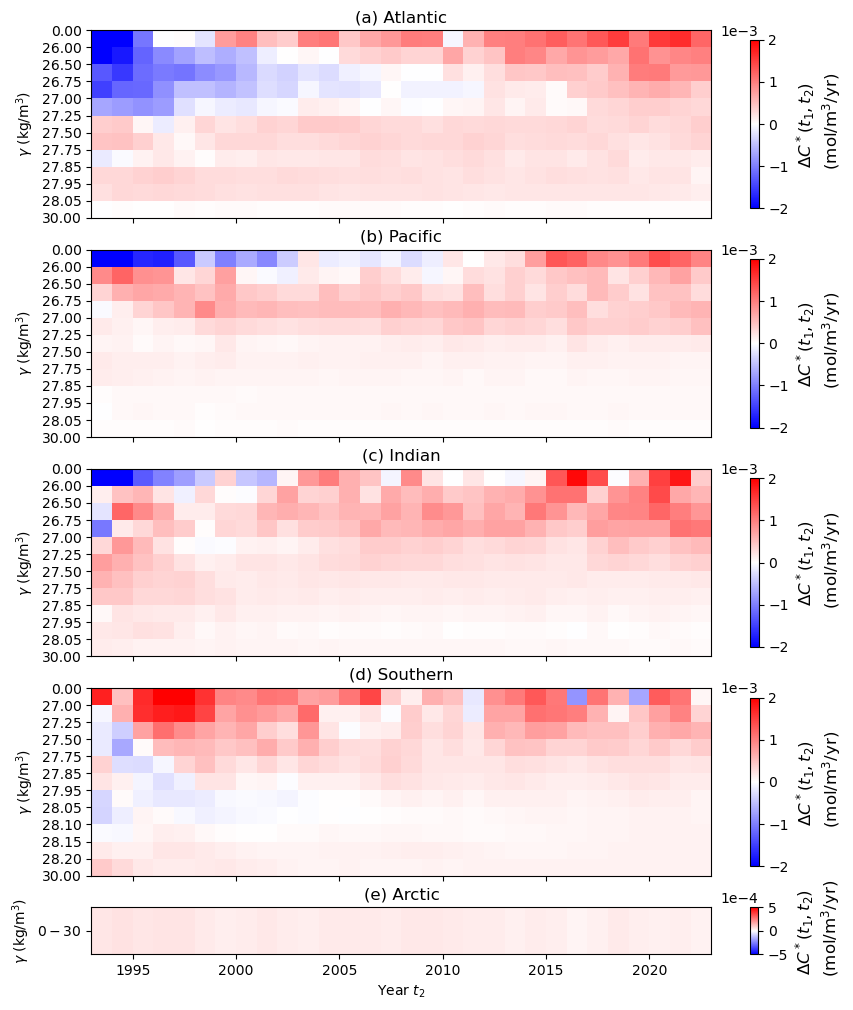

In [22]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, gridspec_kw={'height_ratios': [4, 4, 4, 4, 1]}, sharex=True)
vmax = 0.004
vmax2 = 0.5*vmax
im = ax0.pcolormesh( dCstar_regions[:11,:], vmin = -vmax2, vmax=vmax2, cmap='bwr')
ax0.invert_yaxis()
ax0.set(title = '(a) Atlantic', ylabel=r'$\gamma$ (kg/m$^3$)')
ax0.set_yticks(np.arange(0, 12, 1))
ax0.set_yticklabels(api_ticklabels)
#plt.colorbar(im, ax=ax0)
cbar = fig.colorbar(im, shrink=0.9, ax=ax0)
cbar.set_label('$\Delta C^*(t_1, t_2)$ \n (mol/m$^3$/yr)', fontsize=12)
cbar.formatter.set_powerlimits((0, 0))

im = ax1.pcolormesh( dCstar_regions[11:22,:], vmin = -vmax2, vmax=vmax2, cmap='bwr')
ax1.invert_yaxis()
ax1.set(title = '(b) Pacific', ylabel=r'$\gamma$ (kg/m$^3$)')
ax1.set_yticks(np.arange(0, 12, 1))
ax1.set_yticklabels(api_ticklabels)
cbar = fig.colorbar(im, shrink=0.9, ax=ax1)
cbar.set_label('$\Delta C^*(t_1, t_2)$ \n (mol/m$^3$/yr)', fontsize=12)
cbar.formatter.set_powerlimits((0, 0))

im = ax2.pcolormesh(dCstar_regions[22:33,:], vmin = -vmax2, vmax=vmax2, cmap='bwr')
ax2.invert_yaxis()
ax2.set(title = '(c) Indian', ylabel=r'$\gamma$ (kg/m$^3$)')
ax2.set_yticks(np.arange(0, 12, 1))
ax2.set_yticklabels(api_ticklabels)
cbar = fig.colorbar(im, shrink=0.9, ax=ax2)
cbar.set_label('$\Delta C^*(t_1, t_2)$ \n (mol/m$^3$/yr)', fontsize=12)
cbar.formatter.set_powerlimits((0, 0))

im = ax3.pcolormesh(dCstar_regions[33:44,:], vmin = -vmax2, vmax=vmax2, cmap='bwr')
ax3.invert_yaxis()
ax3.set(title = '(d) Southern', ylabel=r'$\gamma$ (kg/m$^3$)')
ax3.set_yticks(np.arange(0, 12, 1))
ax3.set_yticklabels(so_ticklabels)
cbar = fig.colorbar(im, shrink=0.9, ax=ax3)
cbar.set_label('$\Delta C^*(t_1, t_2)$ \n (mol/m$^3$/yr)', fontsize=12)
cbar.formatter.set_powerlimits((0, 0))

im = ax4.pcolormesh(dCstar_regions[-1,:].reshape((30,1)).T, vmin = -0.25*vmax2, vmax=0.25*vmax2, cmap='bwr')
ax4.invert_yaxis()
ax4.set(title = '(e) Arctic', ylabel=r'$\gamma$ (kg/m$^3$)', xlabel = 'Year $t_2$')
ax4.set_xticks(np.arange(2, 30, 5))
ax4.set_xticklabels(year_ticklabels)
ax4.set_yticks([0.5])
ax4.set_yticklabels(['$0-30$'])
cbar = fig.colorbar(im,  ax=ax4, aspect=6)
cbar.set_label('$\Delta C^*(t_1, t_2)$ \n (mol/m$^3$/yr)', fontsize=12)
cbar.formatter.set_powerlimits((0, 0))

#plt.colorbar(im, ax=ax)
fig.set_size_inches(10, 12)
fig.savefig("../figures/regions_timeseries.png", dpi=600, bbox_inches='tight')